Extractive Summarizer: An extractive summarizer based on a non-deep learning supervised model.
1. In particular, you have to train a non-deep learning classification (e.g. logistic regression, SVM) or regression model (e.g. ElasticNet, SVR) that will be used for scoring the sentences of the input document. (0 or 1)
2. Then, based on the scores, you will create a summarizer that attempts to create a summary with the most informative, non-redundant **sentences**. It is up to you which machine learning model and features you will use.


## Steps

0. Data exploration
1. Preprocessing
2. Feature Extraction
3. Sentence score calculation: similarity of each sentence of the article with each sentence in the highlights based on their Average word2vec embedding.
High scores between pairs denote that the sentence is a good candidate for being added in the summary, so high-scoring sentences will be assigned label 1. Low scoring pairs based on a specific threshold will be assigned label 0.
4. Sentence extraction: extract the n first sentences in the document that have been given a value of 1 in the previous step. (i chose the 3 first)
5. Summary production: these 3 first sentences should be written in a .txt file , where on the left side, we will have the article id: eg
(f001ec5c4704938247d27a44948eebb37ae98d01) and then the 3 extracted sentences as raw text,separated with a fullstop (no lists).
6. the content of 'highlights' column should be compared to the content of the 'ml-summary' column and Compute Rouge 2 metrics in a new column which will contain all 3 requested metrics in a dictionary.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets contractions

In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import numpy as np
import datasets
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import string

In [ ]:
dataset_name = "cnn_dailymail"
dataset_version = "3.0.0"

dataset = datasets.load_dataset(dataset_name, dataset_version)

print(dataset.keys())

In [ ]:
# Convert the datasets to DataFrames, then to csv to be saved.
train_df = pd.DataFrame(dataset['train'])
train_df.to_csv('train.csv')
val_df = pd.DataFrame(dataset['validation'])
val_df.to_csv('val.csv')
test_df = pd.DataFrame(dataset['test'])
test_df.to_csv('test.csv')

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/NLG-&-NLU_Fall-2023/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/NLG-&-NLU_Fall-2023/val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/NLG-&-NLU_Fall-2023/test.csv')

# Data Exploration

In [ ]:
train_df.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [ ]:
val_df.head()

,article,highlights,id
0,"(CNN)Share, and your gift will be multiplied. ...",Zully Broussard decided to give a kidney to a ...,a4942dd663020ca54575471657a0af38d82897d6
1,"(CNN)On the 6th of April 1996, San Jose Clash ...",The 20th MLS season begins this weekend .\nLea...,4157bc4da185971e2742f349d69a037343bc0d95
2,"(CNN)French striker Bafetimbi Gomis, who has a...",Bafetimbi Gomis collapses within 10 minutes of...,60736693e3b1b32d14337a317190c6606e879a85
3,(CNN)It was an act of frustration perhaps more...,Rory McIlroy throws club into water at WGC Cad...,8cdf9cc3ed0276b7a7944cc18ba459355b5984ad
4,(CNN)A Pennsylvania community is pulling toget...,"Cayman Naib, 13, hasn't been heard from since ...",2e6613d531843515bf5401286cc3e45c4df530d2


In [ ]:
test_df.head()

,article,highlights,id
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef
2,"(CNN)If you've been following the news lately,...",Mohammad Javad Zarif has spent more time with ...,4495ba8f3a340d97a9df1476f8a35502bcce1f69
3,(CNN)Five Americans who were monitored for thr...,17 Americans were exposed to the Ebola virus w...,a38e72fed88684ec8d60dd5856282e999dc8c0ca
4,(CNN)A Duke student has admitted to hanging a ...,Student is no longer on Duke University campus...,c27cf1b136cc270023de959e7ab24638021bc43f


In [ ]:
train_df.describe(include='object')

,article,highlights,id
count,287113,287113,287113
unique,284005,282197,287113
top,"SHANGHAI, China (CNN) -- If it weren't for th...",This page includes the show Transcript and the...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
freq,3,83,1


In [ ]:
train_df.info() # No NaN values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287113 entries, 0 to 287112
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   article     287113 non-null  object
 1   highlights  287113 non-null  object
 2   id          287113 non-null  object
dtypes: object(3)
memory usage: 6.6+ MB


In [ ]:
val_df.info() # No NaN values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13368 entries, 0 to 13367
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article     13368 non-null  object
 1   highlights  13368 non-null  object
 2   id          13368 non-null  object
dtypes: object(3)
memory usage: 313.4+ KB


In [ ]:
test_df.info() # No NaN values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11490 entries, 0 to 11489
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article     11490 non-null  object
 1   highlights  11490 non-null  object
 2   id          11490 non-null  object
dtypes: object(3)
memory usage: 269.4+ KB


In [ ]:
print(train_df.duplicated().any())
print(val_df.duplicated().any())
print(test_df.duplicated().any()) # No duplicated rows.

False
False
False


In [ ]:
train_df.columns

Index(['article', 'highlights', 'id'], dtype='object')

In [ ]:
val_df.columns

Index(['article', 'highlights', 'id'], dtype='object')

In [ ]:
test_df.columns

Index(['article', 'highlights', 'id'], dtype='object')

In [ ]:
# Sample half of the rows.
train_sample = train_df.sample(frac=0.5)
val_sample = val_df.sample(frac=0.5)

In [ ]:
def sentence_count(text):
    sentences = sent_tokenize(text)
    return len(sentences)

train_sample['sent_count_art'] = train_sample['article'].apply(sentence_count)
val_sample['sent_count_art'] = val_sample['article'].apply(sentence_count)

train_sample['sent_count_high'] = train_sample['highlights'].apply(sentence_count)
val_sample['sent_count_high'] = val_sample['highlights'].apply(sentence_count)

In [ ]:
# Calculate the total number of sentences for articles and highlights.
total_sents_art = train_sample['sent_count_art'].sum() + val_sample['sent_count_art'].sum()
total_sents_high = train_sample['sent_count_high'].sum() + val_sample['sent_count_high'].sum()

# Count the number of entries (rows) in each column.
num_entries_art = train_sample['sent_count_art'].count() + val_sample['sent_count_art'].count()
num_entries_high = train_sample['sent_count_high'].count() + val_sample['sent_count_high'].count()

average_sentence_count_art = total_sents_art / num_entries_art if num_entries_art != 0 else 0
average_sentence_count_high = total_sents_high / num_entries_high if num_entries_high != 0 else 0

print("Average sentence count in articles:", average_sentence_count_art)
print("Average sentence count in highlights:", average_sentence_count_high)


Average sentence count in articles: 38.76535543130991
Average sentence count in highlights: 3.70122470713525


In [ ]:
# Count words for each article/highlight.
def word_count(text):
    words = word_tokenize(text)
    return len(words)

train_sample['word_count_art'] = train_sample['article'].apply(word_count)
val_sample['word_count_art'] = val_sample['article'].apply(word_count)

train_sample['word_count_high'] = train_sample['highlights'].apply(word_count)
val_sample['word_count_high'] = val_sample['highlights'].apply(word_count)

In [ ]:
print(train_sample.columns)


Index(['article', 'highlights', 'id', 'sent_count_art', 'sent_count_high',
       'word_count_art', 'word_count_high'],
      dtype='object')


In [ ]:
train_sample.head()

,article,highlights,id,sent_count_art,sent_count_high,word_count_art,word_count_high
278626,Thousands of holidaymakers are returning from ...,Outbreak of Chikungunya virus continues to aff...,7d5501db8c6501300b8fbb77f9363e4e95ca49ba,69,6,1469,75
241935,Eating 28g of yoghurt daily - around a quarter...,Research suggests yoghurt could be an easy and...,a80e6d41d5c65ee824dfd74ca4ae5497db22eb9b,24,3,634,46
118257,"By . Graham Smith . PUBLISHED: . 04:33 EST, 16...","David Hang, 43, stabbed Jessica Nguyen 43 time...",fe760ae2f352cb9709ad11b7128b462539ad89bd,45,1,525,21
37428,(CNN) -- The recent focus may have been on his...,Tiger Woods shoots three-under round in solid ...,b063543e48223e748a1cedf4ce8830ff691c62a4,24,4,584,45
212196,A house dating back to the early 1700s once li...,House once in by 'real Robinson Crusoe' has go...,d64c2cabe09e02b878c9e70e51a15bc0e45084bb,50,5,1308,72


In [ ]:
val_sample.head()

,article,highlights,id,word_count_art,word_count_high
1501,"For Dundee United and Celtic, the trilogy beco...",William Hill Scottish Cup quarter-final ended ...,9b440f93fc1d3bb9e44877d1aa9f26d6994063bb,1206,60
12170,Police in Vermont are desperate to speak to Ro...,"Lynne Schulze, 18, vanished in Middlebury, Ver...",ef642c80fece6cb2549702eba0e68c5952af8380,1327,103
883,"(CNN)In ""Game of Thrones,"" Yunkai might be a f...",The town of Ouarzazate is often called Morocco...,c0a2c10f79ab789609153f1bb62c7403def364f7,726,43
2106,A mother and daughter who starved their pet do...,"Rosemary Robinson, 41, and daughter Rachel, 19...",49292a124f44b7ae0d1129a5d34762ec5595cf87,407,40
12781,A five-year-old girl was reported to have been...,The assault was reported to police by a parent...,efe648b361f1cdc7122cc9b209063bf7f7b01b9a,730,73


In [ ]:
# Combine the word counts from both dfs.
combined_word_counts_art = pd.concat([train_sample['word_count_art'], val_sample['word_count_art']])
combined_word_counts_high = pd.concat([train_sample['word_count_high'], val_sample['word_count_high']])

average_word_count_art = combined_word_counts_art.mean()
average_word_count_high = combined_word_counts_high.mean()

print(f"Average number of words per Article in 50% of train and validation datasets combined: {average_word_count_art}")
print(f"Average number of words per Highlight (Summary) in 50% of train and validation datasets combined: {average_word_count_high}")

print(f"Total number of words in Articles in 50% of train and validation datasets combined: {sum(combined_word_counts_art)}")
print(f"Total number of words in Highlights (Summaries) in 50% of train and validation datasets combined: {sum(combined_word_counts_high)}")

Average number of words per Article in 50% of train and validation datasets combined: 690.2779619275825
Average number of words per Highlight (Summary) in 50% of train and validation datasets combined: 51.81904286474973
Total number of words in Articles in 50% of train and validation datasets combined: 103707361
Total number of words in Highlights (Summaries) in 50% of train and validation datasets combined: 7785293


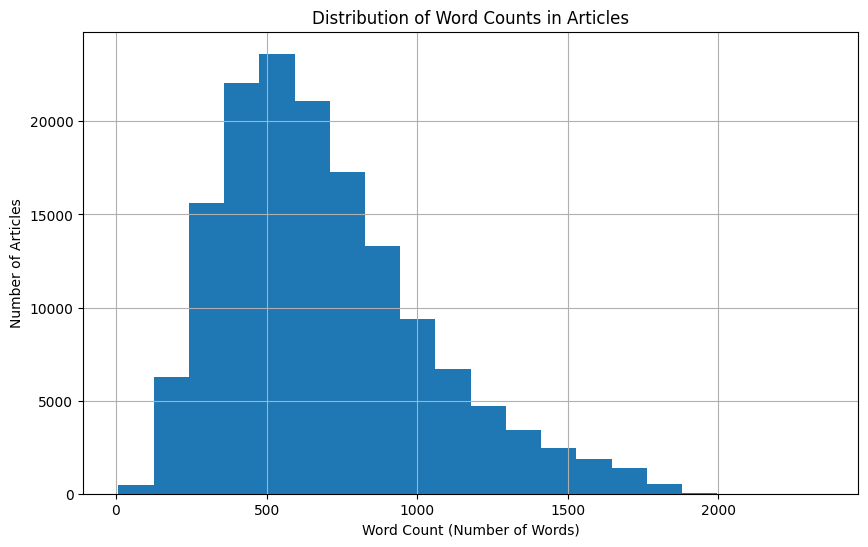

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
combined_word_counts_art.hist(bins=20)
plt.title('Distribution of Word Counts in Articles')
plt.xlabel('Word Count (Number of Words)')
plt.ylabel('Number of Articles')
plt.show()

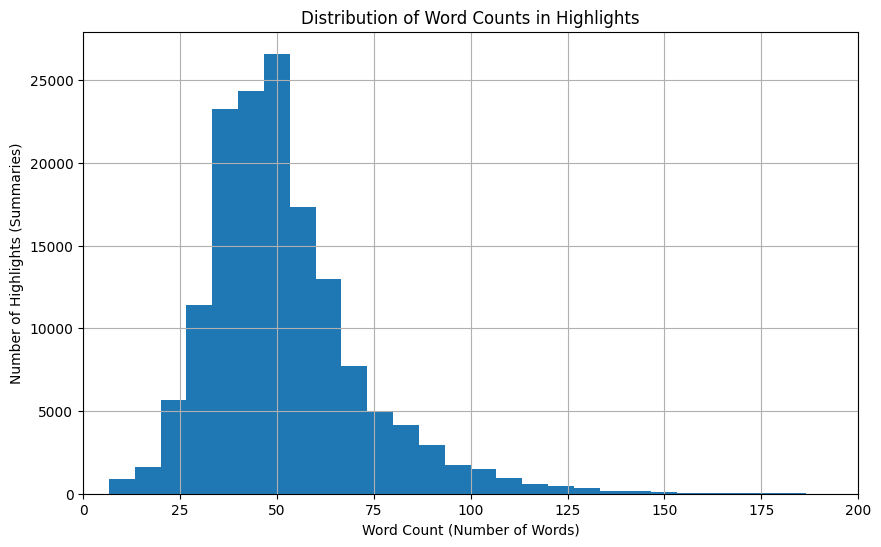

In [ ]:
plt.figure(figsize=(10,6))

# Constrain the x-axis within the range where most of the counts lie, to make visualisation more effective.
max_word_count = 200

combined_word_counts_high.hist(bins=30, range=(0, max_word_count))
plt.title('Distribution of Word Counts in Highlights')
plt.xlabel('Word Count (Number of Words)')
plt.ylabel('Number of Highlights (Summaries)')
plt.xlim(0, max_word_count)
plt.show()

________________________________________________________________________________________